# Project: Insights from failed orders

We are going to do the following things while answering the questions-
- building up a distribution of orders according to reasons for failure: cancellations before and after driver assignment, and the reason for order rejection, analysing the resulting plot to see which category has the highest number of orders.
- Plotting the distribution of failed orders by hours to identify a trend of certain hours having abnormally high proportion of one category or another and also find out what hours are the biggest fails and how that can be explained.
- Plotting the average time to cancellation with and without driver, by the hour to see if there are any outliers within the data and then proceed to remove them and draw further conclusion from the data.
- Plotting the distribution of average ETA by hours and explaining any trend established.
- calculating how many size 8 hexes contain 80% of all orders from the original data sets and visualising the hexes.


<a id="wrangling"></a>
## Data wrangling

Pandas library is used to load the CSVs into a DataFrame

In [96]:
import pandas as pd, numpy as np

In [97]:
orders = pd.read_csv('datasets/data_orders.csv')
offers = pd.read_csv('datasets/data_offers.csv')

In [98]:
# geta sense of the number of entries and features
orders.shape

(10716, 8)

In [99]:
# investigate missing data
orders.isnull().sum()/orders.shape[0]

order_datetime                   0.000000
origin_longitude                 0.000000
origin_latitude                  0.000000
m_order_eta                      0.737402
order_gk                         0.000000
order_status_key                 0.000000
is_driver_assigned_key           0.000000
cancellations_time_in_seconds    0.318122
dtype: float64

We can observe that m_order_eta and cancellations_time_in_seconds have 73% and 31% of entire data missing respectively

In [100]:
#take a look at samples from the data, while specilfying random_state
orders.sample(10,random_state=42)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
10309,00:29:14,-0.966062,51.454821,NaN,3.000000e+12,4,0,44.0
6705,01:28:45,-0.970472,51.456725,NaN,3.000000e+12,4,0,121.0
304,08:22:36,-0.916708,51.439852,NaN,3.000000e+12,9,0,NaN
9143,07:32:27,-0.955580,51.453493,1078.0,3.000000e+12,4,1,1017.0
10593,04:39:55,-0.946358,51.439779,NaN,3.000000e+12,4,0,121.0
8654,08:05:02,-0.967327,51.449395,598.0,3.000000e+12,4,1,48.0
3919,00:21:47,-0.971597,51.457574,NaN,3.000000e+12,4,0,180.0
4337,20:26:40,-0.971296,51.458115,NaN,3.000000e+12,4,0,104.0
6931,07:25:39,-0.942301,51.474812,NaN,3.000000e+12,4,0,44.0
967,13:41:31,-0.952194,51.444067,NaN,3.000000e+12,9,0,NaN


In [101]:
#inspect the data format and missing numbers in dataset
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  float64
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 669.9+ KB


In [102]:
# change order_datetime from string to datetime format
orders.order_datetime = pd.to_datetime(orders.order_datetime)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_datetime                 10716 non-null  datetime64[ns]
 1   origin_longitude               10716 non-null  float64       
 2   origin_latitude                10716 non-null  float64       
 3   m_order_eta                    2814 non-null   float64       
 4   order_gk                       10716 non-null  float64       
 5   order_status_key               10716 non-null  int64         
 6   is_driver_assigned_key         10716 non-null  int64         
 7   cancellations_time_in_seconds  7307 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 669.9 KB


In [103]:
orders.sample(10,random_state=13)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
339,2023-06-15 15:42:16,-0.922114,51.451058,538.0,3.000000e+12,4,1,37.0
7514,2023-06-15 17:49:27,-0.969326,51.433188,658.0,3.000000e+12,4,1,109.0
7918,2023-06-15 00:17:44,-0.948534,51.440262,NaN,3.000000e+12,9,0,NaN
6143,2023-06-15 08:47:39,-0.956305,51.443311,297.0,3.000000e+12,4,1,545.0
8916,2023-06-15 03:24:32,-0.974736,51.454823,60.0,3.000000e+12,4,1,57.0
1064,2023-06-15 08:15:48,-0.963172,51.454195,NaN,3.000000e+12,9,0,NaN
5711,2023-06-15 22:36:55,-0.956702,51.443059,NaN,3.000000e+12,9,0,NaN
2326,2023-06-15 15:24:17,-1.033644,51.445660,297.0,3.000000e+12,4,1,19.0
1966,2023-06-15 03:23:53,-0.944338,51.441401,NaN,3.000000e+12,4,0,203.0
5675,2023-06-15 19:15:22,-0.973507,51.449443,NaN,3.000000e+12,4,0,232.0


In [104]:
# get a sense of the number of entries and features
offers.shape

(334363, 2)

In [105]:
#investigate missing values
offers.isnull().sum()

order_gk    0
offer_id    0
dtype: int64

In [106]:
# investigate data types
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


In [107]:
#  view samples of the data
offers.sample(10,random_state=13)

,order_gk,offer_id
187474,3000596421448,300051566747
147870,3000628807245,300052187786
77639,3000623790996,300051869966
292490,3000625092591,300051972070
38540,3000631156163,300052331409
257777,3000585091766,300051103545
66947,3000627383151,300052079810
253560,3000552920878,300050611078
50980,3000617526191,300051721402
167153,3000628683796,300052174189


In [108]:
# get common columns in both dataset
all_columns = pd.Series(list(offers)+list(orders))
all_columns[all_columns.duplicated()]

6    order_gk
dtype: object

Merge the two datasets for easier wrangling and analysis using the `merge()` method, by merging on `order_gk` column and specifying how the merge is carried our by using the `left` parameter since the `offers` dataset contains all orders(successful and unsuccessful) while `orders` dataset contains only the unsuccessful orders.

In [109]:
df = pd.merge(orders,offers,on='order_gk',how='left')
df.sample(5,random_state=42)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
10309,2023-06-15 00:29:14,-0.966062,51.454821,NaN,3.000000e+12,4,0,44.0,NaN
6705,2023-06-15 01:28:45,-0.970472,51.456725,NaN,3.000000e+12,4,0,121.0,NaN
304,2023-06-15 08:22:36,-0.916708,51.439852,NaN,3.000000e+12,9,0,NaN,NaN
9143,2023-06-15 07:32:27,-0.955580,51.453493,1078.0,3.000000e+12,4,1,1017.0,NaN
10593,2023-06-15 04:39:55,-0.946358,51.439779,NaN,3.000000e+12,4,0,121.0,NaN


It may be better to improve the data quality by making the `order_status_key` and `is_driver_assigned_key` more contextualized by assigning `1`s in `is_driver_assigned` with `Yes` and the `0`s with `No`. And also assigning `4`s in `order_status_key` with `Client_cancelled` and `9`s with `System_rejected`

In [110]:
df['is_driver_assigned_key'] = np.where(df['is_driver_assigned_key']==1,'Yes','No')
df['order_status_key'] = np.where(df['order_status_key']==4,'Client_cancelled','System_rejected')

Rename columns to be more informative

In [111]:
df.columns

Index(['order_datetime', 'origin_longitude', 'origin_latitude', 'm_order_eta',
       'order_gk', 'order_status_key', 'is_driver_assigned_key',
       'cancellations_time_in_seconds', 'offer_id'],
      dtype='object')

In [112]:
cols = {'order_datetime':'order_time',
        'origin_longitude':'longitude',
        'origin_latitude':'latitude',
         'm_order_eta':'ETA',
         'order_gk':'order_id',
         'order_status_key':'order_status',
         'is_driver_assigned_key':'is_driver_assigned',
        'cancellations_time_in_seconds':'cancellation_time'}

df.rename(columns=cols,inplace=True)

In [113]:
df.head()

,order_time,longitude,latitude,ETA,order_id,order_status,is_driver_assigned,cancellation_time,offer_id
0,2023-06-15 18:08:07,-0.978916,51.456173,60.0,3.000000e+12,Client_cancelled,Yes,198.0,NaN
1,2023-06-15 20:57:32,-0.950385,51.456843,NaN,3.000000e+12,Client_cancelled,No,128.0,NaN
2,2023-06-15 12:07:50,-0.969520,51.455544,477.0,3.000000e+12,Client_cancelled,Yes,46.0,NaN
3,2023-06-15 13:50:20,-1.054671,51.460544,658.0,3.000000e+12,Client_cancelled,Yes,62.0,NaN
4,2023-06-15 21:24:45,-0.967605,51.458236,NaN,3.000000e+12,System_rejected,No,NaN,NaN


<a id="EDA"></a>

## Exploratory Data Analysis

## **Question 1**

**Building up a distribution of orders accordig to reasons for failure: cancellations before and after driver assignment, and the reason for order rejection, analysing the resulting plot to see which category has the highest number of orders.**

This is evalutated by using pandas groupby method to group the table by the columns `is_driver_assigned` and `order_status` and counting the number of orders in `order_id` 

In [114]:
cancellations = df.groupby(['is_driver_assigned','order_status'])['order_id'].count()
cancellations

is_driver_assigned  order_status    
No                  Client_cancelled    4496
                    System_rejected     3406
Yes                 Client_cancelled    2811
                    System_rejected        3
Name: order_id, dtype: int64

It is observed that a high number of clients cancelled their order before a driver was assigned, implying that probably customers had waited too long to be assigned a driver and decided on other alternative transport means. There are `7307` order cancelled by the client, and `3409` rejected by the system. `4496` orders were cancelled by Clients before Driver was assigned while `3406` orders were rejected by system.After The Driver was assigned,`2811` orders were cancelled by the Client. 

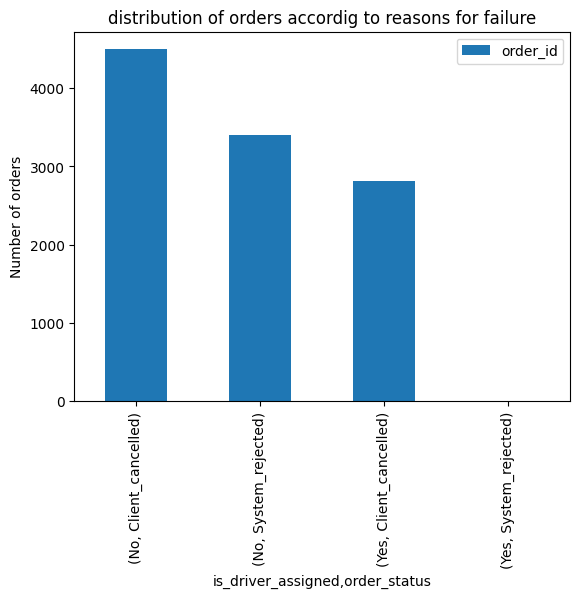

In [115]:
_=cancellations.plot(kind='bar',legend=True,subplots=False,\
                   ylabel='Number of orders',\
                   title='distribution of orders accordig to reasons for failure')

## **Question 2**

**Plotting the distribution of failed orders by hours to identify a trend of certain hours having abnormally high proportion of one category or another and also find out what hours are the biggest fails and how that can be explained**

This further builds on the previous question by looking at the time when these fails occured in an effort establish a trend. To do this the hour of day is extracted from the datetime columns and the failed orders are counted by hour.  


In [116]:
# Extract hour fro datetime column
df['order_hour'] = df.order_time.dt.hour

In [117]:
df.sample(5,random_state=13)

,order_time,longitude,latitude,ETA,order_id,order_status,is_driver_assigned,cancellation_time,offer_id,order_hour
339,2023-06-15 15:42:16,-0.922114,51.451058,538.0,3.000000e+12,Client_cancelled,Yes,37.0,NaN,15
7514,2023-06-15 17:49:27,-0.969326,51.433188,658.0,3.000000e+12,Client_cancelled,Yes,109.0,NaN,17
7918,2023-06-15 00:17:44,-0.948534,51.440262,NaN,3.000000e+12,System_rejected,No,NaN,NaN,0
6143,2023-06-15 08:47:39,-0.956305,51.443311,297.0,3.000000e+12,Client_cancelled,Yes,545.0,NaN,8
8916,2023-06-15 03:24:32,-0.974736,51.454823,60.0,3.000000e+12,Client_cancelled,Yes,57.0,NaN,3


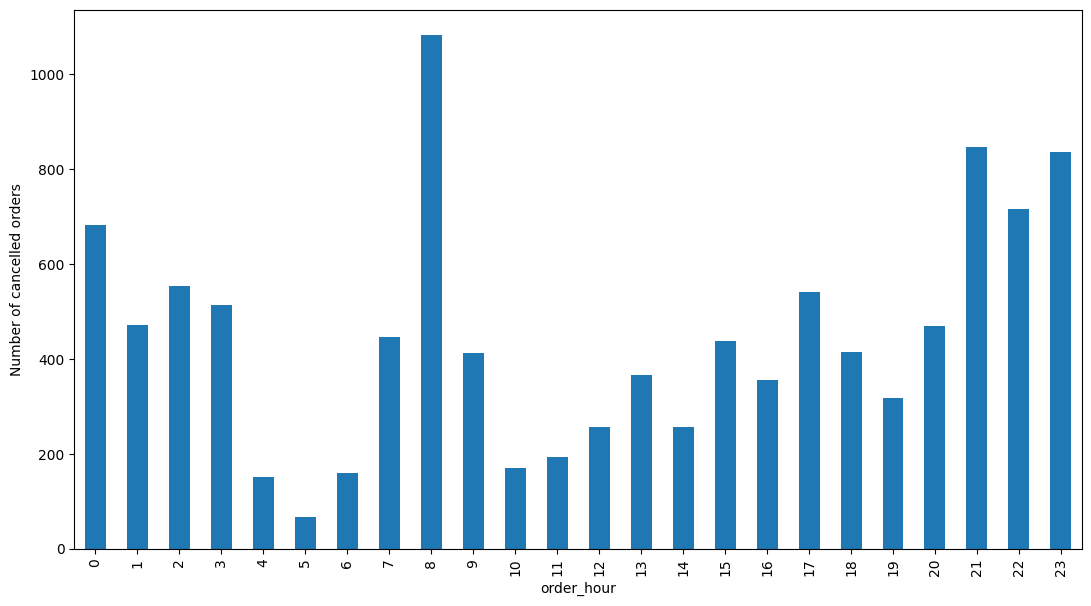

In [118]:
_ = df.groupby('order_hour')['order_id'].count().plot(kind='bar',figsize=(13,7),ylabel='Number of cancelled orders'),


From the bar chart above , it is seen that the highest number of order fails occurred at `8:00`,followed by `21:00` and `23:00`

Failed orders are further investigated by hour by category, to obtain deeper insights into the cancellations by category.

In [119]:
q2 = df.groupby(['order_hour','is_driver_assigned','order_status'])['order_id'].count()
q2                             

order_hour  is_driver_assigned  order_status    
0           No                  Client_cancelled    298
                                System_rejected     263
            Yes                 Client_cancelled    120
                                System_rejected       2
1           No                  Client_cancelled    219
                                System_rejected     164
            Yes                 Client_cancelled     88
2           No                  Client_cancelled    237
                                System_rejected     240
            Yes                 Client_cancelled     78
3           No                  Client_cancelled    224
                                System_rejected     225
            Yes                 Client_cancelled     64
4           No                  Client_cancelled     50
                                System_rejected      61
            Yes                 Client_cancelled     41
5           No                  Client_cancelled     15

<Axes: title={'center': 'Count of failed orders'}, xlabel='order_hour', ylabel='Number of cancelled orders'>

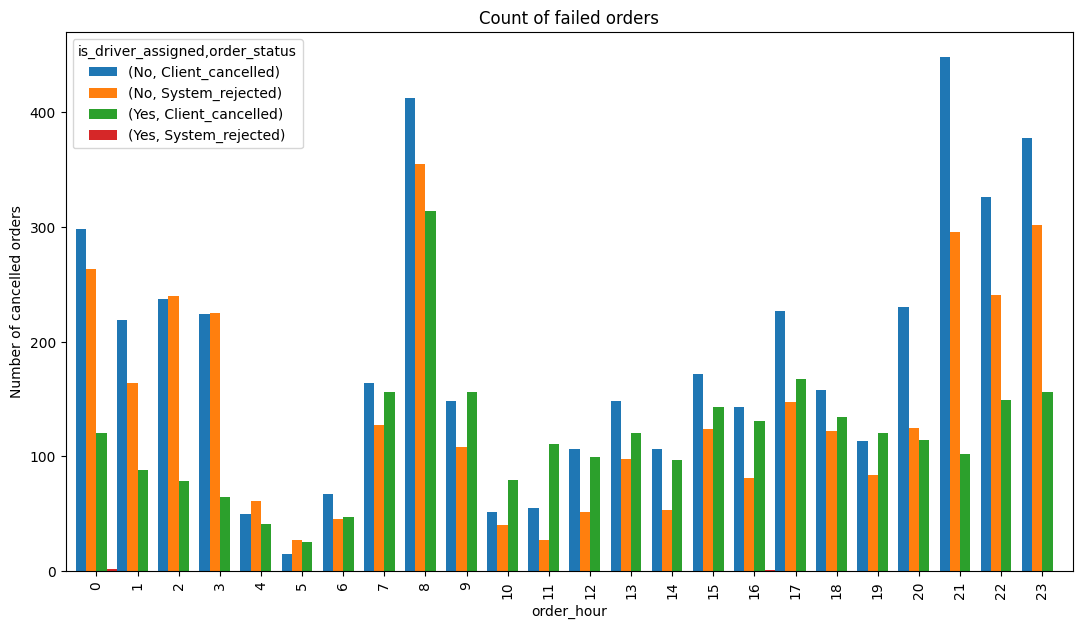

In [120]:
q2.reset_index().pivot(index='order_hour',
         columns=['is_driver_assigned','order_status'],
         values = 'order_id').plot(kind='bar',xticks=range(0,24),
                            figsize=(13,7),width=1,
                            title='Count of failed orders',
                            ylabel= 'Number of cancelled orders')

The detailed plot is quite interesting.
Highest No: of orders cancelled by Client before Driver is assigned occurs at hour **21** while rest of the categories follow the trend of highest order cancellations occuring at hour **8**

## **Question 3**

**Ploting the average time to cancellation with and without driver, by the hour to see it there are any outliers within the data and then proceed to remove them and draw further conclusion from the data**

Again, the same approached as taken with the previous questions are employed. the dataframe is aggregated by the `order_hour` and `is_driver_assigned`, and then `cancelletion_time` is aggregated with the `mean` function  

In [121]:
q3 = df.groupby(['order_hour','is_driver_assigned'])['cancellation_time'].mean()
q3

order_hour  is_driver_assigned
0           No                    111.557047
            Yes                   293.616667
1           No                     98.132420
            Yes                   247.715909
2           No                    106.438819
            Yes                   303.307692
3           No                    104.361607
            Yes                   292.640625
4           No                     90.000000
            Yes                   243.219512
5           No                    121.800000
            Yes                   314.400000
6           No                    124.955224
            Yes                   272.553191
7           No                    112.628049
            Yes                   188.891026
8           No                    120.702179
            Yes                   189.025478
9           No                    120.000000
            Yes                   216.493590
10          No                     74.607843
            Yes         

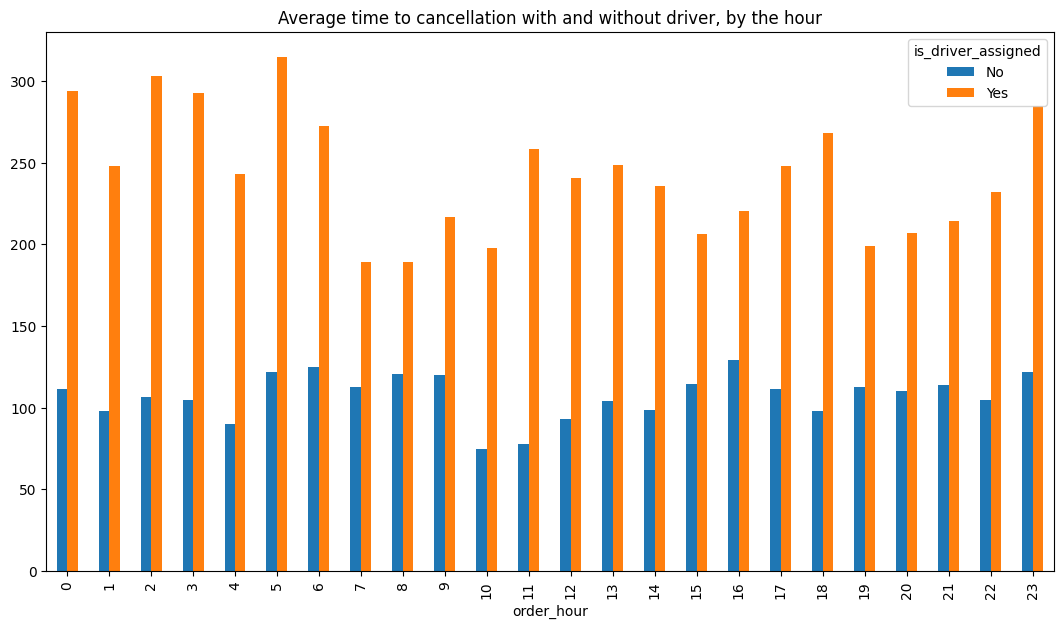

In [122]:
q3.reset_index().pivot(index='order_hour',
         columns='is_driver_assigned',
         values='cancellation_time').plot(kind='bar',
                                          xticks=range(0,24),
                                          figsize=(13,7),
                                          title='Average time to cancellation with and without driver, by the hour');

The average time to cancellation is higher on with an assigned driver than those without assigned driver for each hour without exception.The peak occurred at Hour `5`.Next peak occurred at Hour `2`.Another Interesting point to note is that Hour `5` has the lowest total no: of order cancellations out of all hours thus indicating that average time to cancellation for hour 5 has a small sample size.

## **Question 4**
**Plotting the distribution of average ETA by hours and explaining any trend established.**

We simply group-by the DataFrame on the order hour, and aggregate the m_order_eta column with a mean function. Then, we plot the resulting DataFrame. The result is in the cell immediately below.

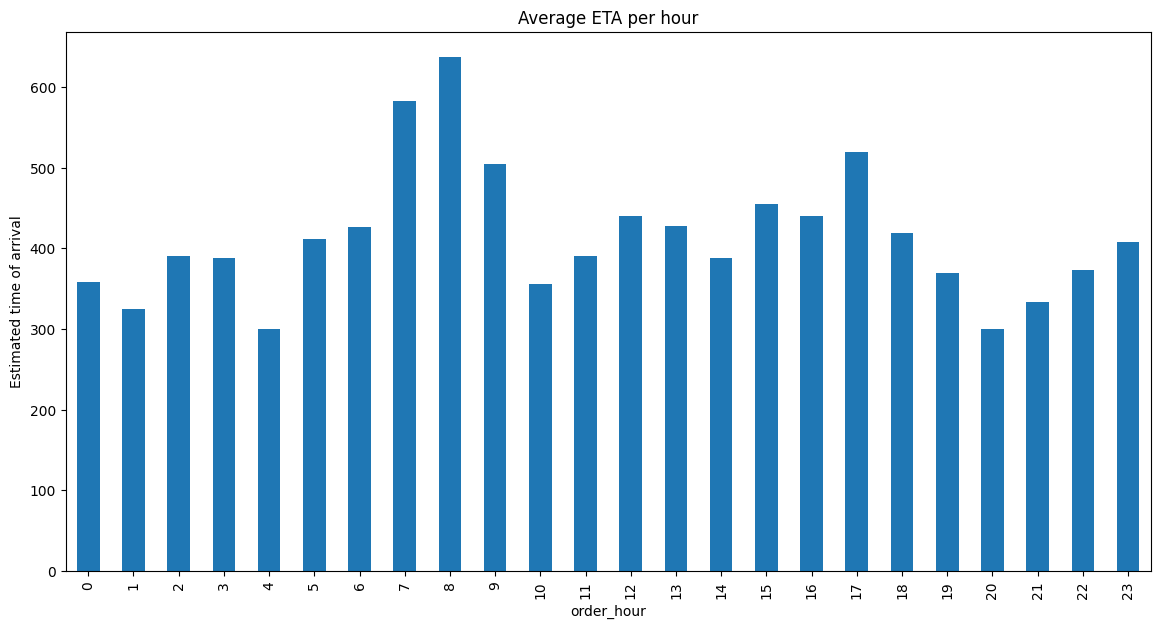

In [123]:
_ = df.groupby(by="order_hour")["ETA"].mean().plot(kind='bar',figsize=(14, 7),
                     xticks=range(0, 24),
                     ylabel='Estimated time of arrival',
                     title="Average ETA per hour")

The bar charts very closely matches the count of total failed orders per hour, indicating that the number of failed orders increases as the average waiting time of the client increases.

In [124]:
df.head()

,order_time,longitude,latitude,ETA,order_id,order_status,is_driver_assigned,cancellation_time,offer_id,order_hour
0,2023-06-15 18:08:07,-0.978916,51.456173,60.0,3.000000e+12,Client_cancelled,Yes,198.0,NaN,18
1,2023-06-15 20:57:32,-0.950385,51.456843,NaN,3.000000e+12,Client_cancelled,No,128.0,NaN,20
2,2023-06-15 12:07:50,-0.969520,51.455544,477.0,3.000000e+12,Client_cancelled,Yes,46.0,NaN,12
3,2023-06-15 13:50:20,-1.054671,51.460544,658.0,3.000000e+12,Client_cancelled,Yes,62.0,NaN,13
4,2023-06-15 21:24:45,-0.967605,51.458236,NaN,3.000000e+12,System_rejected,No,NaN,NaN,21


## **Question 5**
**calculating how many size 8 hexes contain 80% of all orders from the original data sets and visualising the hexes**

In [125]:
import h3
import folium

In [126]:
df["hex_id"] = df.apply(
    func=lambda row: h3.geo_to_h3(lat=row["latitude"], lng=row["longitude"],\
                                  resolution=8), axis=1)


In [127]:
grouped_q5 = df.groupby(by='hex_id')["order_id"].count()
grouped_q5.shape

(144,)

In [128]:
grouped_q5 = grouped_q5.reset_index()
grouped_q5.sample(n=5,random_state=42)

,hex_id,order_id
117,88195d2b51fffff,98
19,88195d284bfffff,8
82,88195d2aebfffff,2
97,88195d2b1dfffff,1497
56,88195d2a15fffff,21


To find the number of hexes that contain 80% of the orders, we will apply a cumulative percentage operation over the order_id count column in the grouped_q5 DataFrame. This consists of the following steps:
1. Sort the DataFrame by the count. 
2. Find the total number (sum) of failed orders. 
3. Apply the method cumsum to find the cumulative sum of the order count column. 
4. Divide by the total sum to generate percentages. 
5. Filter to find the row that is closest to 80%.

In [129]:
grouped_q5 = grouped_q5.sort_values(by="order_id") # 1
total_orders = grouped_q5["order_id"].sum() # 2
grouped_q5["cum_sum"] = grouped_q5["order_id"].cumsum() # 3
grouped_q5["cum_perc"] = 100 * grouped_q5["cum_sum"] / total_orders # 4
grouped_q5[grouped_q5["cum_perc"] <= 80] # 5

,hex_id,order_id,cum_sum,cum_perc
72,88195d2a3bfffff,1,1,0.009332
142,88195d74d5fffff,1,2,0.018664
3,88195d2807fffff,1,3,0.027996
7,88195d281dfffff,1,4,0.037327
8,88195d2821fffff,1,5,0.046659
124,88195d2b69fffff,1,6,0.055991
59,88195d2a1bfffff,1,7,0.065323
74,88195d2a45fffff,1,8,0.074655
126,88195d3993fffff,1,9,0.083987
82,88195d2aebfffff,2,11,0.102650


There are `144` rows in the final output, and `142` rows in the original grouped DataFrame, meaning that `142` hexagons contain around 80% of data, and only 2 hexagons contain the other 20%!

In [130]:
map = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()],
 zoom_start=8.5, # after a bit of experimentation, I thought this presents the map best
 tiles="cartodbpositron"
 )

In [131]:
import json
import geojson
def to_geojson(row):    
    """
    Transform hex_id into a geojson object.
    """
    geometry = {
    "type": "Polygon",
    "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"], geo_json=True)]
                }
    result = geojson.Feature(id=row["hex_id"], geometry=geometry, properties={"order_id":row['order_id']})
    return result
                                                                                                                                                
geojsons = grouped_q5.apply(func=to_geojson, axis=1).values.tolist()
geojson_str: str = json.dumps(geojson.FeatureCollection(geojsons))
                                                                              

In [132]:

import matplotlib
# instantiate a colormap object for better visualisation
colormap = matplotlib.cm.get_cmap(name="plasma")
max_order_gk = grouped_q5["order_id"].max()
min_order_gk = grouped_q5["order_id"].min()


C:\Users\Admin\AppData\Local\Temp\ipykernel_784\230931784.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = matplotlib.cm.get_cmap(name="plasma")


In [133]:
_ = folium.GeoJson(data=geojson_str, style_function=lambda f: {
 "fillColor": matplotlib.colors.to_hex(
 colormap((f["properties"]["order_id"]-min_order_gk)/(max_order_gk - min_order_gk))),
 "color": "black",
 "weight": 1,
 "fillOpacity": 0.7
}).add_to(map)

In [134]:
map

Thus,The Yellow Hexagon(containing the Town `Reading`) has the highest no: of cancelled orders and should be investigated further 